# Optimization and Topological Data Analysis

In this notebook, we are going to see how to combine Gudhi and Tensorflow in order to do persistence optimization!

In [1]:
import numpy                 as np
import tensorflow            as tf
import matplotlib.pyplot     as plt
import pandas                as pd
import gudhi                 as gd
from tqdm                    import tqdm
from gudhi.tensorflow        import LowerStarSimplexTreeLayer, CubicalLayer, RipsLayer

from utils import *
from utilsTopology import *

2025-02-25 18:09:54.699185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740503395.442000    3634 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740503395.635065    3634 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 18:09:56.015356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Calculate diagram with gudhi and with my code, comparison

## My code

In [2]:
domain =[-10,10]
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), 250)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

persistence_layer = LowerStarPersistenceBasic(maxdim=0)

max_valueRef = y_train_tensor.max()
dgmsRef = persistence_layer(y_train_tensor)
dgmsRef[dgmsRef==float('inf')] = max_valueRef
print(dgmsRef)

tensor([[-0.5440,  0.9997],
        [-0.9997,  0.9999],
        [-0.9999,  1.0000],
        [-1.0000,  1.0000]])


## Gudhi code

In [4]:
stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarSimplexTreeLayer(simplextree=stbase, homology_dimensions=[0])
dgm = layer.call(tf.Variable(y_train))
print(dgm)

[(<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[-0.54402111,  0.99974336],
       [-0.99974336,  0.99990761],
       [-0.99990761,  0.99998973]])>, <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-0.99998973]])>)]


In [19]:
print(dgm[0][0])
persistence = tf.experimental.numpy.diff(dgm[0][0])
persistence = tf.boolean_mask(tf.abs(persistence), tf.math.is_finite(persistence))
print(persistence)
P = tf.reduce_sum(persistence)
probabilities = persistence / P
print(probabilities)
log_prob = tf.zeros_like(probabilities)
mask = probabilities > 0
log_prob = tf.tensor_scatter_nd_update(log_prob, tf.where(mask), tf.math.log(probabilities[mask]))
print(log_prob)
print(-tf.reduce_sum(probabilities * log_prob))

tf.Tensor(
[[-0.54402111  0.99974336]
 [-0.99974336  0.99990761]
 [-0.99990761  0.99998973]], shape=(3, 2), dtype=float64)
tf.Tensor([1.54376447 1.99965096 1.99989734], shape=(3,), dtype=float64)
tf.Tensor([0.27849132 0.36073212 0.36077657], shape=(3,), dtype=float64)
tf.Tensor([-1.2783684  -1.01961965 -1.01949645], shape=(3,), dtype=float64)
tf.Tensor(1.09163448061323, shape=(), dtype=float64)


### understanding the gudhi code step by step

In [72]:
stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10)
for sg in stbase.get_skeleton(1):
    print(sg)

([0, 1], -10000000000.0)
([0], -10000000000.0)
([1, 2], -10000000000.0)
([1], -10000000000.0)
([2, 3], -10000000000.0)
([2], -10000000000.0)
([3, 4], -10000000000.0)
([3], -10000000000.0)
([4, 5], -10000000000.0)
([4], -10000000000.0)
([5, 6], -10000000000.0)
([5], -10000000000.0)
([6, 7], -10000000000.0)
([6], -10000000000.0)
([7, 8], -10000000000.0)
([7], -10000000000.0)
([8, 9], -10000000000.0)
([8], -10000000000.0)
([9, 10], -10000000000.0)
([9], -10000000000.0)
([10, 11], -10000000000.0)
([10], -10000000000.0)
([11, 12], -10000000000.0)
([11], -10000000000.0)
([12, 13], -10000000000.0)
([12], -10000000000.0)
([13, 14], -10000000000.0)
([13], -10000000000.0)
([14, 15], -10000000000.0)
([14], -10000000000.0)
([15, 16], -10000000000.0)
([15], -10000000000.0)
([16, 17], -10000000000.0)
([16], -10000000000.0)
([17, 18], -10000000000.0)
([17], -10000000000.0)
([18, 19], -10000000000.0)
([18], -10000000000.0)
([19, 20], -10000000000.0)
([19], -10000000000.0)
([20, 21], -10000000000.0)
([

In [74]:
stbase.reset_filtration(-np.inf,0)
for sg in stbase.get_skeleton(1):
    print(sg)

([0, 1], -inf)
([0], -inf)
([1, 2], -inf)
([1], -inf)
([2, 3], -inf)
([2], -inf)
([3, 4], -inf)
([3], -inf)
([4, 5], -inf)
([4], -inf)
([5, 6], -inf)
([5], -inf)
([6, 7], -inf)
([6], -inf)
([7, 8], -inf)
([7], -inf)
([8, 9], -inf)
([8], -inf)
([9, 10], -inf)
([9], -inf)
([10, 11], -inf)
([10], -inf)
([11, 12], -inf)
([11], -inf)
([12, 13], -inf)
([12], -inf)
([13, 14], -inf)
([13], -inf)
([14, 15], -inf)
([14], -inf)
([15, 16], -inf)
([15], -inf)
([16, 17], -inf)
([16], -inf)
([17, 18], -inf)
([17], -inf)
([18, 19], -inf)
([18], -inf)
([19, 20], -inf)
([19], -inf)
([20, 21], -inf)
([20], -inf)
([21, 22], -inf)
([21], -inf)
([22, 23], -inf)
([22], -inf)
([23, 24], -inf)
([23], -inf)
([24, 25], -inf)
([24], -inf)
([25, 26], -inf)
([25], -inf)
([26, 27], -inf)
([26], -inf)
([27, 28], -inf)
([27], -inf)
([28, 29], -inf)
([28], -inf)
([29, 30], -inf)
([29], -inf)
([30, 31], -inf)
([30], -inf)
([31, 32], -inf)
([31], -inf)
([32, 33], -inf)
([32], -inf)
([33, 34], -inf)
([33], -inf)
([34, 35]

In [77]:
for i in range(stbase.num_vertices()):
    stbase.assign_filtration([i], y_train[i])
stbase.make_filtration_non_decreasing()
for sg in stbase.get_skeleton(1):
    print(sg)

([0, 1], 0.5440211108893698)
([0], 0.5440211108893698)
([1, 2], 0.474944315636295)
([1], 0.474944315636295)
([2, 3], 0.4028050599180419)
([2], 0.4028050599180419)
([3, 4], 0.3280685006200653)
([3], 0.3280685006200653)
([4, 5], 0.25121654214803285)
([4], 0.25121654214803285)
([5, 6], 0.17274472908842567)
([5], 0.17274472908842567)
([6, 7], 0.09315905091666726)
([6], 0.09315905091666726)
([7, 8], 0.012972679356205725)
([7], 0.012972679356205725)
([8, 9], -0.06729734057386186)
([8], -0.06729734057386186)
([9, 10], -0.14713342448630656)
([9], -0.14713342448630656)
([10, 11], -0.22602078603117917)
([10], -0.22602078603117917)
([11, 12], -0.3034507562593444)
([11], -0.3034507562593444)
([12, 13], -0.37892406354076386)
([12], -0.37892406354076386)
([13, 14], -0.4519540528884961)
([13], -0.4519540528884961)
([14, 15], -0.5220698239300383)
([14], -0.5220698239300383)
([15, 16], -0.5888192672922927)
([15], -0.5888192672922927)
([16, 17], -0.6517719798213716)
([16], -0.6517719798213716)
([17, 18]

In [80]:
# Compute persistence diagram
stbase.compute_persistence(homology_coeff_field=11, persistence_dim_max=0)
    
# Get vertex pairs for optimization. First, get all simplex pairs
pairs = stbase.lower_star_persistence_generators() # este paso es el que hace que no coja la barra del punto mas bajo y lo añada aparte.
# https://github.com/GUDHI/gudhi-devel/blob/master/src/python/gudhi/simplex_tree.pyx linea 745, ves que el infinite lo lleva por otra lado.
pairs

([array([[249, 222],
         [ 27,  66],
         [183, 144]])],
 [array([105])])

In [86]:
np.argmax(y_train)

np.int64(144)

In [103]:
L_indices = []
for dimension in [0]:

    finite_pairs = pairs[0][dimension] if len(pairs[0]) >= dimension+1 else np.empty(shape=[0,2])
    finite_pairs = np.vstack((finite_pairs,[np.argmin(y_train).item(),np.argmax(y_train).item()])) # esta linea es clave para tener la ultima barra.
    essential_pairs = pairs[1][dimension] if len(pairs[1]) >= dimension+1 else np.empty(shape=[0,1])
    
    finite_indices = np.array(finite_pairs.flatten(), dtype=np.int32)
    essential_indices = np.array(essential_pairs.flatten(), dtype=np.int32)

    L_indices.append((finite_indices, essential_indices))

L_indices

[(array([249, 222,  27,  66, 183, 144, 105, 144], dtype=int32),
  array([105], dtype=int32))]

In [109]:
dgms = []
indices = L_indices
for idx_dim, dimension in enumerate([0]):
    finite_dgm = tf.reshape(tf.gather(y_train, indices[idx_dim][0]), [-1,2])
    essential_dgm = tf.reshape(tf.gather(y_train, indices[idx_dim][1]), [-1,1])
    min_pers = 0
    if min_pers >= 0:
        persistent_indices = tf.where(tf.math.abs(finite_dgm[:,1]-finite_dgm[:,0]) > min_pers)
        dgms.append((tf.reshape(tf.gather(finite_dgm, indices=persistent_indices),[-1,2]), essential_dgm))
    else:
        dgms.append((finite_dgm, essential_dgm))
dgms

[(<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
  array([[-0.54402111,  0.99974336],
         [-0.99974336,  0.99990761],
         [-0.99990761,  0.99998973],
         [-0.99998973,  0.99998973]])>,
  <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-0.99998973]])>)]

## Gudhi adapted code: version created by myself in utilsTopology

In [5]:
stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgm = layer.call(tf.Variable(y_train))
print(dgm)

[(<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[-0.54402111,  0.99974336],
       [-0.99974336,  0.99990761],
       [-0.99990761,  0.99998973],
       [-0.99998973,  0.99998973]])>, <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-0.99998973]])>)]


# Persistent entropy calculation in tensorflow and pytorch with my code, to see if it is the same

## Pytorch

In [8]:
domain =[-10,10]
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), 250)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

persistence_layer = LowerStarPersistenceBasic(maxdim=0)

max_valueRef = y_train_tensor.max()
dgmsRef = persistence_layer(y_train_tensor)
dgmsRef[dgmsRef==float('inf')] = max_valueRef
print(dgmsRef)

entropy = persistent_entropyTorch(dgmsRef)
print(entropy)
entropyLim = persistent_entropyTorchLim(dgmsRef)
print(entropyLim)

tensor([[-0.5440,  0.9997],
        [-0.9997,  0.9999],
        [-0.9999,  1.0000],
        [-1.0000,  1.0000]])
tensor(1.3806)
tensor(10.4140)


## Tensorflow

In [10]:
stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgm = layer.call(tf.Variable(y_train))
dgmsRef =dgm[0][0]
print(dgmsRef)

entropy = persistent_entropy_tf(dgmsRef)
print(entropy)
entropyLim = persistent_entropy_lim_tf(dgmsRef)
print(entropyLim)


tf.Tensor(
[[-0.54402111  0.99974336]
 [-0.99974336  0.99990761]
 [-0.99990761  0.99998973]
 [-0.99998973  0.99998973]], shape=(4, 2), dtype=float64)
tf.Tensor(1.3805638112988432, shape=(), dtype=float64)
tf.Tensor(10.413996279592022, shape=(), dtype=float64)


# Regression

Gudhi can also optimize the persistence diagram of a simplicial complex filtered by the lower-star filtration induced by its vertices. Pretty much like for images, the parameters $\theta$ that we are now going to optimize are the vertex values themselves, and the gradients associated to the point $p=(f_\theta(\sigma_+(p)), f_\theta(\sigma_-(p)))$ is simply 1 on all vertices that are part of $\sigma_+(p)$ and $\sigma_-(p)$ and $0$ for all other vertices. All of that is implemented in `LowerStarSimplexTreeLayer`.

We are going to illustrate this on a regression task $Y=X\cdot\beta^*+\epsilon$, where $X\in {\mathbb R}^{n\times p}$, $Y\in {\mathbb R}^{n}$, $\beta^*\in {\mathbb R}^{p}$ and $\epsilon$ is a small random noise. Moreover, the unknown coefficients $\beta^*$ have a specific shape, that we assume is known as a prior. 

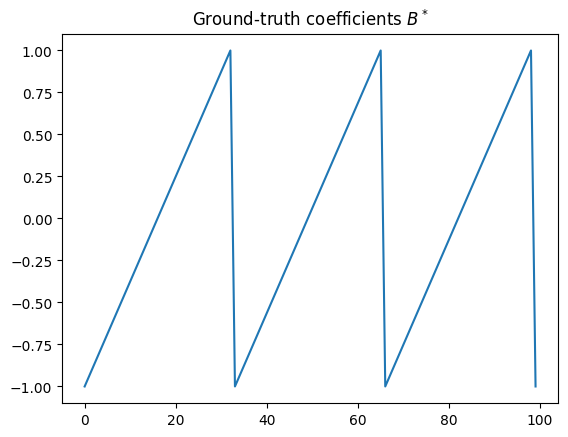

tf.Tensor(
[[-1.  1.]
 [-1.  1.]
 [-1.  1.]], shape=(3, 2), dtype=float64)


In [21]:
np.random.seed(0)
n, p = 50, 100
betastar = np.concatenate([np.linspace(-1.,1.,33) for _ in range(3)] + [[-1.]])

stbase = gd.SimplexTree()
for i in range(p-1):
    stbase.insert([i,i+1], -1e10)
    
layer = LowerStarSimplexTreeLayer(simplextree=stbase, homology_dimensions=[0])
# layer = LowerStarLayer(simplextree=stbase)
plt.figure()
plt.plot(betastar)
plt.title('Ground-truth coefficients $B^*$')
plt.show()

dgmBetaStar = layer.call(tf.Variable(betastar))[0][0]
print(dgmBetaStar)

Es decir sabemos que esta es la distribucion de los coeficientes perfectas que queremos tener, que viene caracterizada por un diagrama de persistencia de 4 barras obviamente, los 4 minimos

Indeed, when we plot the coefficients, the line they form has three high peaks and four low peakes, that can be detected with 0-dimensional persistent homology. Our task will be to find $\beta^*$, knowing that its 0-dimensional persistence diagram should have three points.

Let's first generate the data.

(50, 100)
(50,)


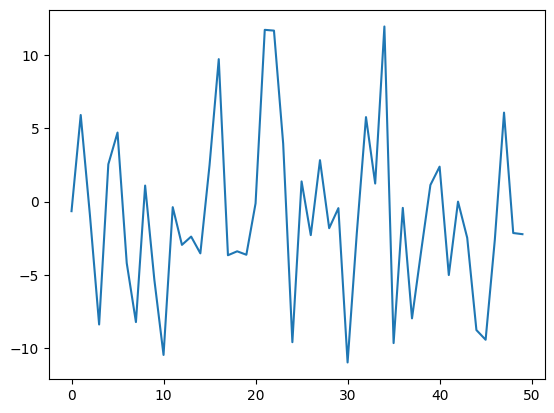

In [24]:
X = np.array(np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n), dtype=np.float32)
Y = np.array(np.matmul(X, betastar) + .05 * np.random.randn(n), dtype=np.float32)
print(X.shape) # 50 muestras con 100 caracteristicas
print(Y.shape)

plt.plot(Y)
plt.show()

We also store the line formed by the coefficients in a simplex tree, es decir el complejo simplicial de una serie temporal así, es que uno forma una arista con el siguiente, así sucesivamente

In [25]:
stbase = gd.SimplexTree()
for i in range(p-1):
    stbase.insert([i,i+1], -1e10)

Here's our initial (random) guess for $\beta^*$, es decir lo que queremos aproximar a lo supuestamente mejor caso

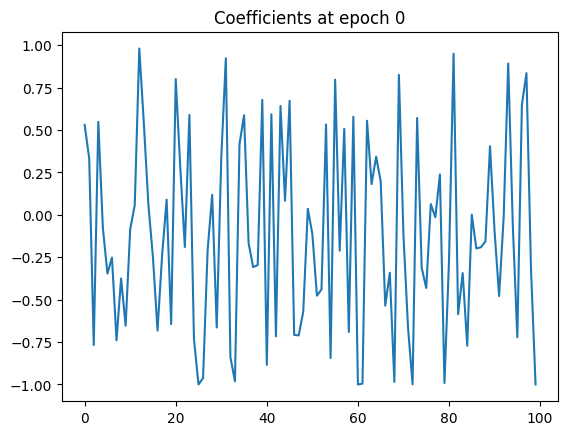

In [29]:
betainit = np.random.uniform(low=-1., high=1., size=[p]) # p es el numero de puntos
betainit[np.array([25,60,99])] = np.array([-1,-1,-1])

plt.figure()
plt.plot(betainit)
plt.title('Coefficients at epoch 0')
plt.show()

For the sake of comparison, we will optimize the coefficients with different losses: using no regularization, using total variation, and using total variation and 0-dimensional persistent homology (i.e., forcing the 0-dimensional persistence diagram to have only three points).

Let's first optimize the initial coefficients without any penalty.

In [68]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses_mse, betas = [], []
for epoch in range(100+1):
    with tf.GradientTape() as tape:
        loss = 2 * tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y))
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)    

    optimizer.apply_gradients(zip(gradients, [beta]))
    losses_mse.append(loss.numpy())
    betas.append(beta.numpy()[:,0])
    
beta_std = -betas[-1]

Now, let's try with total variation.

In [69]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses_msetot, betas = [], []
for epoch in range(100+1):
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + 1e3 * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)

    optimizer.apply_gradients(zip(gradients, [beta]))
    losses_msetot.append(loss.numpy())
    betas.append(beta.numpy()[:,0])
                 
beta_stdtot = -betas[-1]

Finally, let's also add a topological regularization with `LowerStarSimplexTreeLayer`.

In [70]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
layer = LowerStarSimplexTreeLayer(simplextree=stbase, homology_dimensions=[0])
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses_msetop, dgms, betas = [], [], []
for epoch in range(100+1):    
    with tf.GradientTape() as tape:
        dgm = layer.call(beta)[0][0] #dimension 0 y codigo de barras de las barras finitas, es decir las caracteristicas
        # Minimize all points except the three most persistent ones
        top3 = np.argsort(dgm[:,1]-dgm[:,0]).ravel()[::-1][3:]
        loss =  tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + 1e4 * tf.reduce_sum(tf.abs(tf.gather_nd(dgm[:,1]-dgm[:,0], [[idx] for idx in top3]))) \
             + 1e3 * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [beta]))
    losses_msetop.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])

beta_stdtop = -betas[-1]

Let's also try with persistent entropy as loss function (dgm beta star - dgm beta epoca)

In [71]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
layer = LowerStarSimplexTreeLayer(simplextree=stbase, homology_dimensions=[0])
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses_pe, dgms, betas = [], [], []
for epoch in range(100+1):    
    with tf.GradientTape() as tape:
        dgm = layer.call(beta)[0][0] #dimension 0 y codigo de barras de las barras finitas, es decir las caracteristicas
        # lossFunction = PersistentEntropyLossTF()
        lossFunction = PersistentEntropyLossLimTF()
        loss = lossFunction(dgmBetaStar,dgm)
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    # gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [beta]))
    losses_pe.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])

beta_peloss = -betas[-1]

Let's also try with persistent entropy as regularization(adding to the mse loss) (dgm beta star - dgm beta epoca)

In [72]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
layer = LowerStarSimplexTreeLayer(simplextree=stbase, homology_dimensions=[0])
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses_msepe, dgms, betas = [], [], []
for epoch in range(100+1):    
    with tf.GradientTape() as tape:
        dgm = layer.call(beta)[0][0] #dimension 0 y codigo de barras de las barras finitas, es decir las caracteristicas
        # loss =  tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
        #      + 1e4 * tf.reduce_sum(tf.abs(tf.gather_nd(dgm[:,1]-dgm[:,0], [[idx] for idx in top3]))) \
        #      + 1e3 * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
        # lossFunction = PersistentEntropyLossTF()
        lossFunction = PersistentEntropyLossLimTF()
        loss = tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) + lossFunction(dgmBetaStar,dgm)
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [beta]))
    losses_msepe.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])

beta_msepe = -betas[-1]

Let's compare the results!

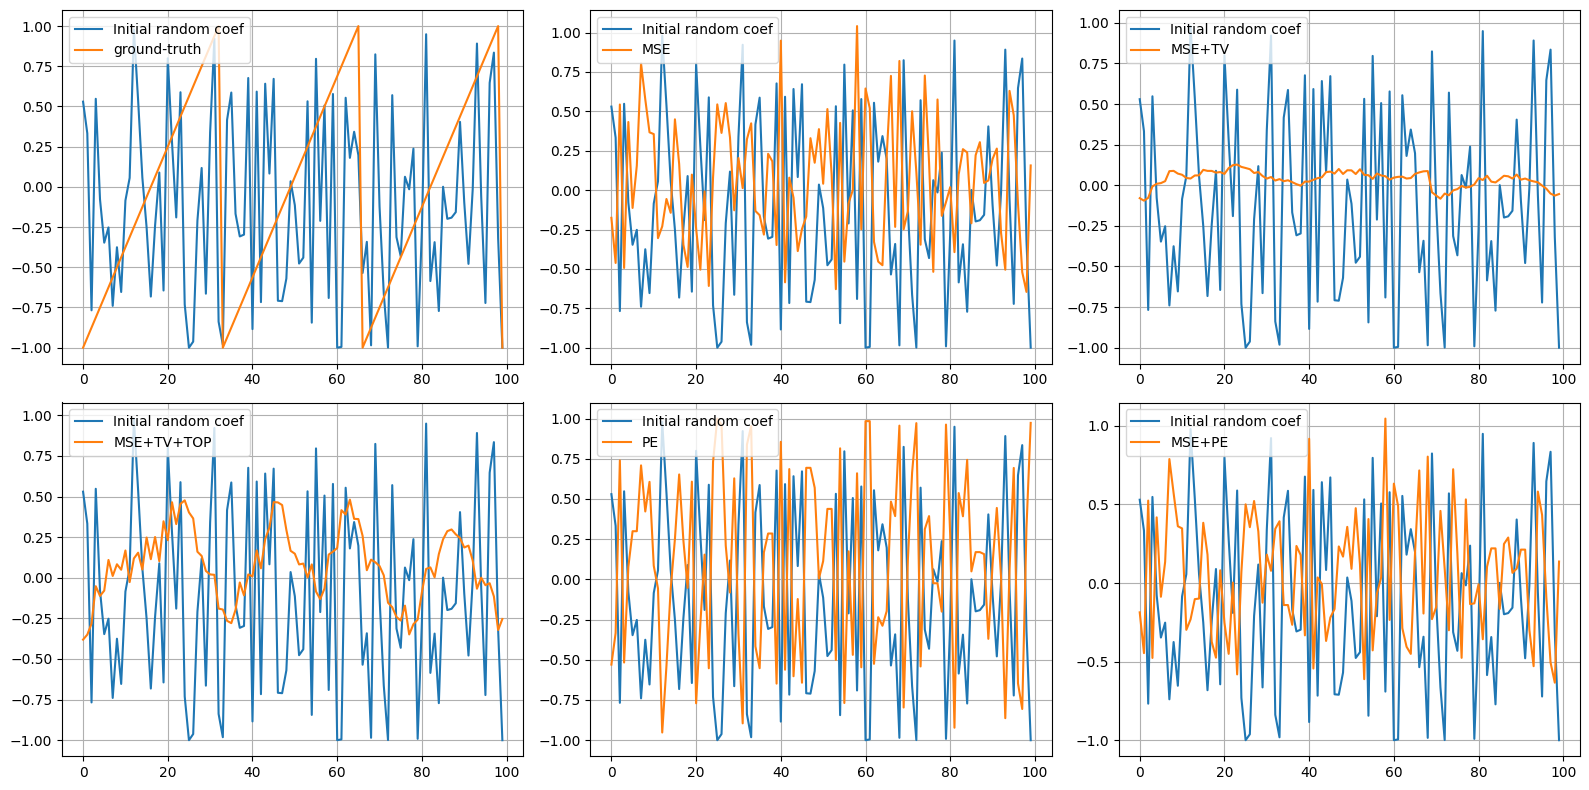

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))  # 3 filas, 2 columnas
axes = axes.flatten()  # Aplanar para indexar fácilmente

# Lista de datos y etiquetas
datos = [
    (betastar, 'ground-truth'),
    (beta_std, 'MSE'),
    (beta_stdtot, 'MSE+TV'),
    (beta_stdtop, 'MSE+TV+TOP'),
    (beta_peloss, 'PE'),
    (beta_msepe, 'MSE+PE')
]

# Graficar cada conjunto en su subplot correspondiente
for ax, (beta, label) in zip(axes, datos):
    ax.plot(betainit,label="Initial random coef")
    ax.plot(beta, label=label)
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()  # Ajustar espacios entre subplots
plt.show()

Using all penalties is the best: while mean square error (MSE) looks pretty random and total variation (TV) shrinks the coefficients too much,
    topology (TOP) achieves the best compromise. This can be further validated by computing the MSE on new test sets: in average, the MSE of the coefficients optimized with topology is lower than the others.

/tmp/ipykernel_3634/2316400567.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([MSEstd, MSEtot, MSEtop, PE, MSEPE], labels=['MSE', 'MSE+TV', 'MSE+TV+TOP', 'PE','MSE+PE'])


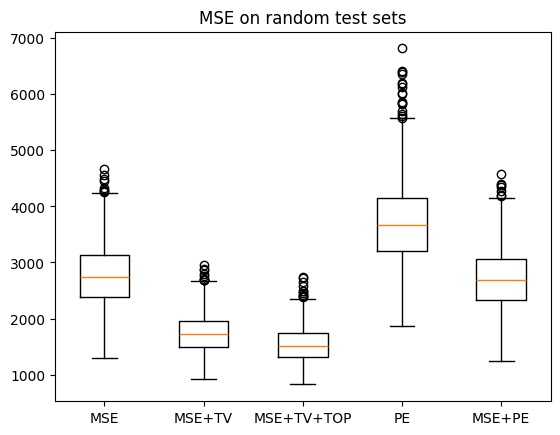

In [65]:
MSEstd, MSEtop, MSEtot, PE, MSEPE = [], [], [], [], []
for s in range(1000):
    np.random.seed(s)
    Xnew = np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n)
    Ynew = np.matmul(Xnew, betastar)
    mse_std = np.square(np.matmul(Xnew, beta_std) - Ynew).sum()
    mse_tot = np.square(np.matmul(Xnew, beta_stdtot) - Ynew).sum()
    mse_top = np.square(np.matmul(Xnew, beta_stdtop) - Ynew).sum()
    pe = np.square(np.matmul(Xnew, beta_peloss) - Ynew).sum()
    mse_pe = np.square(np.matmul(Xnew, beta_msepe) - Ynew).sum()
    MSEstd.append(mse_std)
    MSEtot.append(mse_tot)
    MSEtop.append(mse_top)
    PE.append(pe)
    MSEPE.append(mse_pe)
    
plt.figure()
plt.boxplot([MSEstd, MSEtot, MSEtop, PE, MSEPE], labels=['MSE', 'MSE+TV', 'MSE+TV+TOP', 'PE','MSE+PE'])
plt.title('MSE on random test sets')
plt.show()

Finally, we can have again a look at the convergence and iterates, that is the learning curve

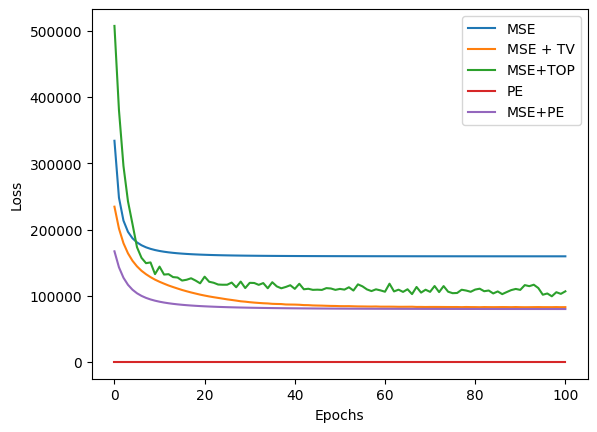

In [75]:
plt.figure()
plt.plot(losses_mse, label="MSE")
plt.plot(losses_msetot, label="MSE + TV")
plt.plot(losses_msetop, label="MSE+TOP")
plt.plot(losses_pe, label="PE")
plt.plot(losses_msepe, label="MSE+PE")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

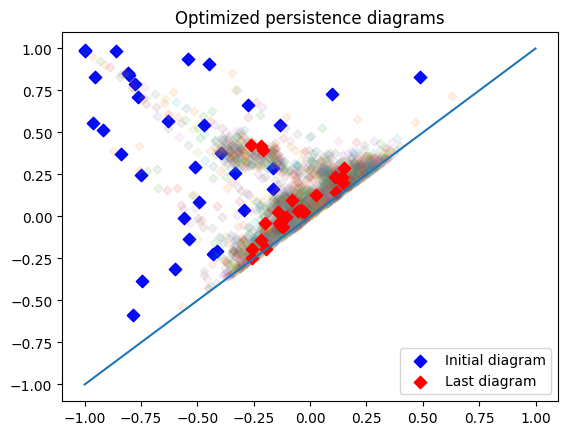

In [34]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue', label = "Initial diagram")
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red',label = "Last diagram")
plt.plot([-1,1], [-1,1])
plt.legend()
plt.title('Optimized persistence diagrams')
plt.show()

Lo que quiere es que las caracteristicas tiendan lo maximo posible a la diagonal excepto las 3 princiaples como estamos viendo, vease los puntos rojos